In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Consider a 1D analog of Poisson's equation, namely $y''=F(x)$, with Dirichlet boundary conditions at $x=a$ and $x=b$.  The "Galerkin method", which is the basis of the finite element method, proceeds as follows.

Given a set of weight functions, $w_i(x)$ defined on $[a,b]$, show that requiring
\begin{equation}
  \int_a^b w_i(x)\ R(x)\, dx = 0
\end{equation}
where $R(x)\equiv y''(x)-F(x)$ is "the residual" and we approximate $y$ as
\begin{equation}
  y(x) \approx \sum_i c_i w_i(x)
\end{equation}
gives a set of simultaneous equations for the coefficients, $c_i$.

Typically the $w_i$ are compact and simply translated versions of a "master"
weight function, e.g. a triangle function.  The first derivative of the
triangle function is non-zero at only 3 places.  In this case use integration
by parts to express the system in a simple form.
(If we take the weight functions in the integral to be $\delta$-functions
 we also get a set of constraints on the $c_i$: this is known as the
 "colocation method".  Berkeley plays an important role in the history
of the FEM, which is not often taught in physics classes.  You can find
good textbooks and resources online.)

The first statement is obvious by simply plugging the expansion for $y$ into the $N$ integral equations, one obtains
\begin{equation}
  \int_a^b \left[\sum_j c_j w_j''(x)-F(x)\right] w_i(x)\, dx = 0
  \quad \Rightarrow \quad
  c_j = \left[\int_a^b w_j''(x)w_i(x)\right]^{-1} \int_a^b F(x)w_i(x)\, dx
\end{equation}
where the notation $[\cdots]^{-1}$ indicates a matrix inverse.

Usually we integrate the $w''w$ term by parts to write the integral in terms of $-(w')^2$ (we can discard the boundary terms if $w$ drops to zero at the edges).  This is known as converting the system to "weak form", and is an important part of FEMs.

Let's take our computational domain to be $[0,1]$ and discretize it with a uniform grid such that $x_i=i h$ where $i\in [0,N]$ and $h=1/N$.  Note that there are $N+1$ points if we include the endpoints.

We will define the weight function $w_i(x)$ to be the triangle function turning on at $x_{i-1}$, peaking at $x_i$ and dropping to $x_{i+1}$.  For the end cases, $i=0$ and $i=N$, we just omit the rise and fall (respectively).

The case $N=3$ is instructive.  Our domain is $[0,1]$ and $x_0=0$, $x_1=1/3$, $x_2=2/3$ and $x_3=1$ with $h=1/3$.  The weight function $w_0(x)$ falls linearly from $1$ at $x=0$ to $0$ at $x_1=1/3$ and is zero elsewhere.  Similarly $w_3(x)$ is zero except between $x=x_2=2/3$ and $x_3=1$ over which interval it rises from $0$ to $1$.  The other two are triangle functions, e.g. $w_1$ rises linearly from $0$ at $x_0$ to $1$ at $x_1$ and then drops linearly from $x_1$ to $x_2$ and is zero from $x_2$ to $x_3$.  Etc.

In this case, with $N=3$ we have
$$
A = h^{-1} \left(\begin{array}{rrrr}
             -1 &  1 &  0 &  0 \\
              1 & -2 &  1 &  0 \\
              0 &  1 & -2 &  1 \\
              0 &  0 &  1 & -1
\end{array}\right) =
h^{-1} \left(\begin{array}{rrrr}
             -1 &  1 &  0 &  0 \\
              1 & -1 &  0 &  0 \\
              0 &  0 &  0 &  0 \\
              0 &  0 &  0 &  0
\end{array}\right) +
h^{-1} \left(\begin{array}{rrrr}
              0 &  0 &  0 &  0 \\
              0 & -1 &  1 &  0 \\
              0 &  1 & -1 &  0 \\
              0 &  0 &  0 &  0
\end{array}\right) +
h^{-1} \left(\begin{array}{rrrr}
              0 &  0 &  0 &  0 \\
              0 &  0 &  0 &  0 \\
              0 &  0 & -1 &  1 \\
              0 &  0 &  1 & -1
\end{array}\right)
$$
since, if we use integration by parts,
$$
  A_{00} = -\int_0^{1/3} (-3)^2 = -3 = -\frac{1}{h} \quad , \quad
  A_{01} = -\int_0^{1/3} (-3)(+3) = 3 = \frac{1}{h}
$$
etc.

If we had a source function, $F$, then the right hand side would be
$$
  \frac{h}{2}\left(\begin{array}{r} F_0 \\ 2F_1 \\ 2F_2 \\ F_3 \end{array}\right)
$$

Now if you went ahead and tried to solve this system, you would find $A$ is singular.  That's because we haven't used the boundary conditions yet.  There are really only two unknowns here, $y_1$ and $y_2$.  So our system isn't really $4\times 4$ but rather $2\times 2$.  There are ways to "trick" the computer into knowing this ... let's add a "penalty term" $\alpha$ to $A_{00}$ and $\beta$ to $A_{33}$ and adjust the rhs to:
$$
  F + \alpha \left(\begin{array}{r} d_0 \\ 0 \\ 0 \\ d_3 \end{array}\right)
$$
which for large $\alpha$ and $\beta$ will force $y_0=d_0$ and $y_3=d_3$ (I'm using "d" for "Dirichlet" here).

Let us also take $F=0$ and the boundary conditions $y(0)=1$ and $y(1)=0$.
This is not a very interesting problem, but it serves to get us going!

In [2]:
# Let's code up this case:
N = 3
h = 1.0/float(N)
x = np.arange(N+1) * h
# Set up the array as above.
A = np.array( [ [-1.0, 1.0, 0.0, 0.0],\
                [ 1.0,-2.0, 1.0, 0.0],\
                [ 0.0, 1.0,-2.0, 1.0],\
                [ 0.0, 0.0, 1.0,-1.0] ])
# Add the penality terms
alpha,beta = 1e4,1e4
A[ 0, 0] += alpha
A[-1,-1] += beta
# There are "clever" and fast ways to invert a tri-diagonal matrix.
# ... we won't use them :).
Ainv = np.linalg.inv(A)
# and solve our system
rhs = np.array([alpha,0,0,0])
y   = np.dot(Ainv,rhs)
# and print the answer, just for fun.
for i in range(N+1):
    print("x={:4.2f}, y={:6.3f}, exact={:6.3f}".format(i*h,y[i],1-i*h))

x=0.00, y= 1.000, exact= 1.000
x=0.33, y= 0.667, exact= 0.667
x=0.67, y= 0.333, exact= 0.333
x=1.00, y=-0.000, exact= 0.000


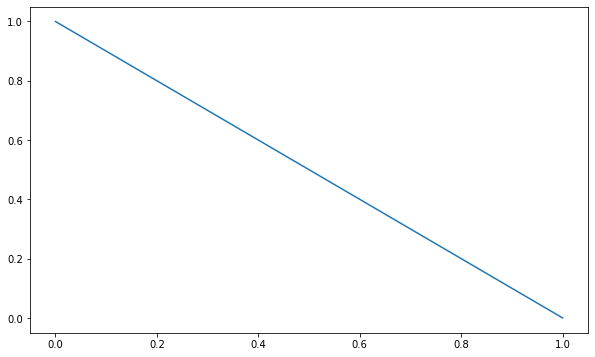

In [3]:
# Let's plot this -- not that we really need to, but ...
fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(x,y)

In [4]:
# What if we decide to do the same thing, but for a larger N?
# Now we construct the A matrix in a loop, by using the fact
# that it can be built from simple shifted copies of a 2x2 matrix.
N = 10
h = 1.0/float(N)
A = np.zeros((N+1,N+1))
Ak= np.zeros((N+1,N+1))
Ak[0,0]=Ak[1,1]=-1.0
Ak[0,1]=Ak[1,0]= 1.0
#
for k in range(N):
    A += Ak
    Ak = np.roll(np.roll(Ak,1,0),1,1)
print(A)

[[-1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -2.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -2.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1. -2.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1. -2.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1. -2.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. -2.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1. -2.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1. -2.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -1.]]


In [5]:
# Again add out penalty terms
A[ 0, 0] += alpha
A[-1,-1] += beta
# Brute-force invert the matrix
Ainv = np.linalg.inv(A)
# and solve our system
rhs = np.zeros(N+1)
rhs[0]=alpha
y   = np.dot(Ainv,rhs)
#
for i in range(N+1):
    print("x={:4.2f}, y={:6.3f}, exact={:6.3f}".format(i*h,y[i],1-i*h))

x=0.00, y= 1.000, exact= 1.000
x=0.10, y= 0.900, exact= 0.900
x=0.20, y= 0.800, exact= 0.800
x=0.30, y= 0.700, exact= 0.700
x=0.40, y= 0.600, exact= 0.600
x=0.50, y= 0.500, exact= 0.500
x=0.60, y= 0.400, exact= 0.400
x=0.70, y= 0.300, exact= 0.300
x=0.80, y= 0.200, exact= 0.200
x=0.90, y= 0.100, exact= 0.100
x=1.00, y=-0.000, exact= 0.000


Note: there is no requirement here that the triangles all be the same size -- the spacing of the triangles can change allowing us to put more resolution in some regions of the problem than others.

The finite element method "feels" different to physicists who don't often use these matrix-like methods.  You can find a nice introduction to the method in the textbook
`The finite element method for engineers` by Huebner, Dewhirst, Smith and Byrom.